# Profitability using the Investment Formula

I've previously talked about crafting an [Investment Formula][1] that would guarantee making money if you could predict which direction the stock market was going to go. This is going to be the first in a series of posts trying to flesh out what an actual investment strategy based on this formula would look like.

But first, the formula doesn't take into account two very important things: **leverage**, and the **number of days invested**. That's why I want to set up what I'm going to call the **Profitability Score**.

The definition is going to be very simple:

- $p$: Profit made once you exit the investment
- $i$: Initial investment into the asset
- $m$: Maximum investment in the asset
- $l = m / i$: The maximum leverage of an investment, as the ratio of maximum invested to initial investment
- $d$: The number of days it takes to turn a profit

$s = \frac{1000 p}{i(l + d)} = \frac{1000 p}{m + i\cdot d}$

Crazy, right? The score is simply the (normalized) profit you made divided by the leverage plus days invested. The $\cdot 1000$ is just to turn the number into something more reasonable - people don't like hearing something with a profitability score of .001 for example.

# Theoretical Justification

The formula itself is designed to be simple in principle: I like making a profit, and I want to penalize the leverage you incur and days you have to invest. Ideally, we want to have a stock that goes up all the time. However, the investment formula takes advantage of a different case: trying to profit from highly volatile assets. If we can make money when the investment only has one day up, let's do it!

Even so, there are two potential issues: First, stocks that trend upward will have a higher profitability score - both leverage and days invested will be 1. To protect against only investing in this trend, I can do things like taking $\log(d)$. I don't want to start biasing the scoring function until I have a practical reason to do so, so right now I'll leave it standing.

The second issue is how to penalize leverage and days invested relative to each other. As it currently stands, a leverage of 6x with only 1 day invested is the same as leveraging 2x with 3 days invested. In the future, I'd again want to look at making the impact of days invested smaller - I can get over an extra 3 days in the market if it means that I don't have to incur a highly leveraged position.

So there could be things about the scoring function we change in the future, but I want to run some actual tests before we start worrying about things like that!

# Running a simulation

This won't be an incredibly rigorous backtest, I just want to see some results from the work so far. Let's set up the simulation code again, and start looking into some random stocks. **If you've read the last blog post, you can skip over the code.** The only difference is that it's been ported to python to make the data-wrangling easier. Julia doesn't yet support some of the multi-index things I'm trying to do.

[1]: https://bspeice.github.io/guaranteed-money-maker.html

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Quandl import get as qget
%matplotlib inline
api_key = ''

profitability = lambda p, i, m, d: 1000*p / (m + i*d)

def is_profitable(current_price, purchase_history, open_history):
    shares = (purchase_history / open_history).sum()
    return current_price * shares > sum(purchase_history)

def daily_investment(current_open, current_close, purchase_history, open_history):
    t1 = current_close / current_open - 1
    t2 = (purchase_history - purchase_history * current_close / open_history).sum()
    return t2 / t1

def simulate_day(open_vals, close_vals, init, expected, bias):
    invested = np.array([init])
    
    day = 1
    profitable = is_profitable(close_vals[day-1], invested, open_vals[0:len(invested)]) \
        or is_profitable(open_vals[day], invested, open_vals[0:len(invested)])

    while not profitable:
        expected_close = open_vals[day] * expected
        todays_purchase = daily_investment(open_vals[day], expected_close, invested, open_vals[0:day])
        invested = np.append(invested, todays_purchase + bias)
        # expected_profit = expected_close * (invested / open_vals[0:len(invested)]).sum() - invested.sum()
        day += 1
        profitable = is_profitable(close_vals[day-1], invested, open_vals[0:len(invested)]) \
            or is_profitable(open_vals[day], invested, open_vals[0:len(invested)])
            
    shares = (invested / open_vals[0:len(invested)]).sum()
    
    # Make sure we can't see into the future - we know either today's close or tomorrow's open
    # will be profitable, but we need to check which one.
    if is_profitable(close_vals[day-1], invested, open_vals[0:len(invested)]):
        ending_price = close_vals[day-1]
    else:
        ending_price = open_vals[day]
        
    profit = shares * ending_price - sum(invested)
    return invested, profit

def simulate_ts(name, start, end, initial, expected, bias):
    ticker_info = qget(name, trim_start=start, api_key=api_key)
    evaluation_times = ticker_info[:end].index
    
    # Handle Google vs. YFinance data
    if "Adjusted Close" in ticker_info.columns:
        close_column = "Adjusted Close"
    else:
        close_column = "Close"
        
    sim = {d: simulate_day(ticker_info[d:]["Open"], ticker_info[d:][close_column],
                       100, 1.02, 10) for d in evaluation_times}
    sim_series = pd.Series(sim)
    result = pd.DataFrame()
    result["profit"] = sim_series.apply(lambda x: x[1])
    result["max"] = sim_series.apply(lambda x: max(x[0]))
    result["days"] = sim_series.apply(lambda x: len(x[0]))
    result["score"] = sim_series.apply(lambda x: profitability(x[1], x[0][0], max(x[0]), len(x[0])))
    result["investments"] = sim_series.apply(lambda x: x[0])
    
    return result

def simulate_tickers(tickers):
    from datetime import datetime
    results = {}
    for ticker in tickers:
        start = datetime(2015, 1, 1)
        results_df = simulate_ts(ticker, start, datetime(2016, 1, 1), 100, 1.01, 10)
        results[ticker] = results_df
        
    return pd.concat(list(results.values()), keys=list(results.keys()), axis=1)

# And now the interesting part

Let's start looking into the data! FANG stocks have been big over the past year, let's see how they look:

In [7]:
fang_df = simulate_tickers(["YAHOO/FB", "YAHOO/AAPL", "YAHOO/NFLX", "YAHOO/GOOG"])

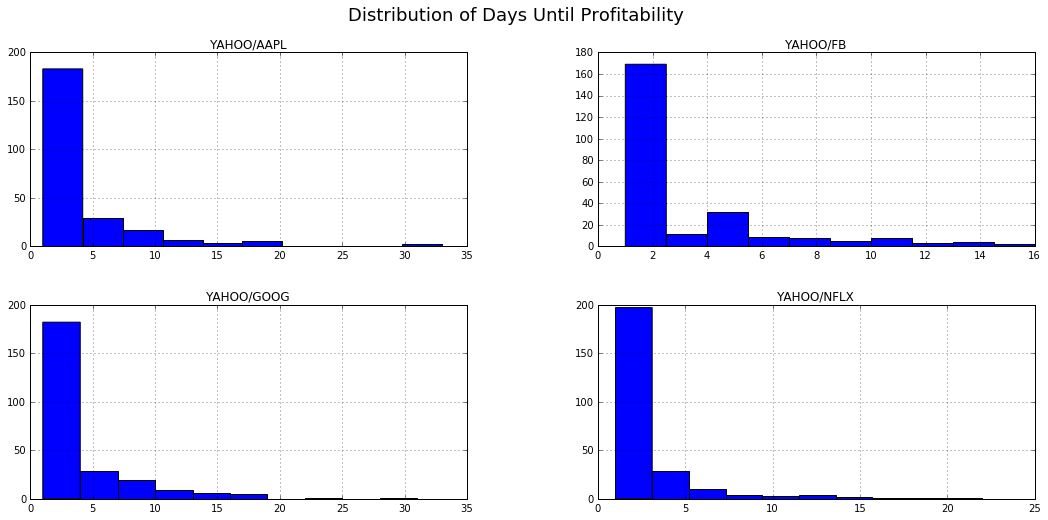

In [8]:
fang_df.xs('days', axis=1, level=1).hist()
plt.gcf().set_size_inches(18, 8);
plt.gcf().suptitle("Distribution of Days Until Profitability", fontsize=18);

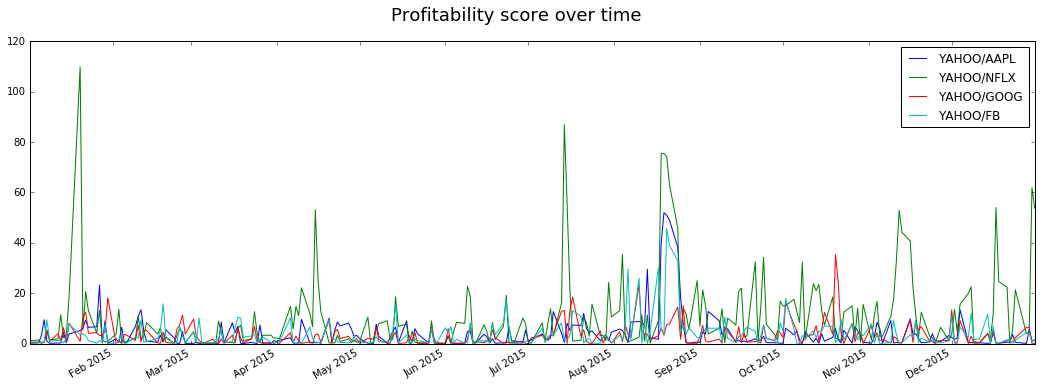

In [10]:
fang_df.xs('score', axis=1, level=1).plot()
plt.gcf().set_size_inches(18, 6)
plt.gcf().suptitle("Profitability score over time", fontsize=18);

Let's think about these graphs. First, the histogram. What we like seeing is a lot of 1's - that means there were a lot of days that the stock went up and we didn't have to worry about actually implementing the strategy - we were able to close the trade at a profit.

Looking at the profitability score over time though is a bit more interesting. First off, stocks that are more volatile will tend to have a higher profitability score, no two ways about that. However, Netflix consistently outperformed on this metric. We know that 2015 was a good year for Netflix, so that's a (small) sign the strategy is performing as expected.

The final interesting note happens around the end of August 2015. Around this period, the markets were selling off in a big way due to issues in China (not unlike what's happening now). Even so, all of the FANG stocks saw an uptick in profitability around this time. This is another sign that the strategy being developed performs better during periods of volatility, rather than from riding markets up or down.

What about FANG vs. some cyclicals?

In [13]:
cyclic_df = simulate_tickers(["YAHOO/X", "YAHOO/CAT", "YAHOO/NFLX", "YAHOO/GOOG"])

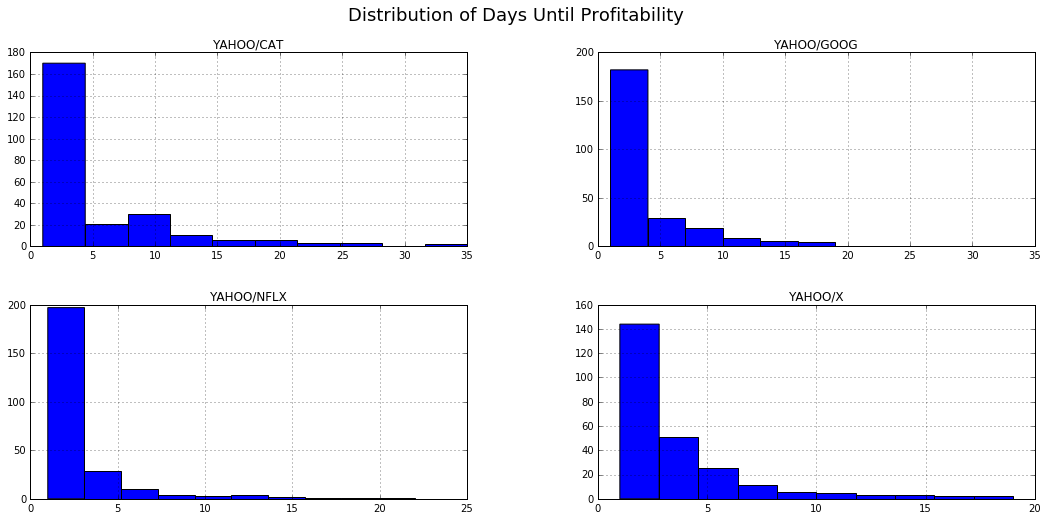

In [14]:
cyclic_df.xs('days', axis=1, level=1).hist()
plt.gcf().set_size_inches(18, 8);
plt.gcf().suptitle("Distribution of Days Until Profitability", fontsize=18);

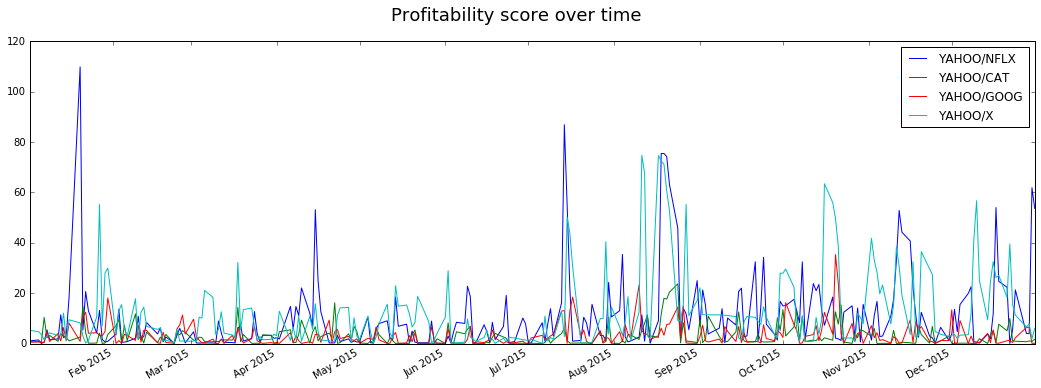

In [15]:
cyclic_df.xs('score', axis=1, level=1).plot()
plt.gcf().set_size_inches(18, 6)
plt.gcf().suptitle("Profitability score over time", fontsize=18);

Some more interesting results come from this as well. First off, US Steel (X) has a much smoother distribution of days until profitability - it doesn't have a huge number of values at 1 and then drop off. Intuitively, we're not terribly large fans of this, we want a stock to go up! However, on the profitability score it is the only serious contender to Netflix.

Second, we see the same trend around August - the algorithm performs well in volatile markets.

For a final test, let's try some biotech and ETFs!

In [21]:
biotech_df = simulate_tickers(['YAHOO/REGN', 'YAHOO/CELG', 'GOOG/NASDAQ_BIB', 'GOOG/NASDAQ_IBB'])

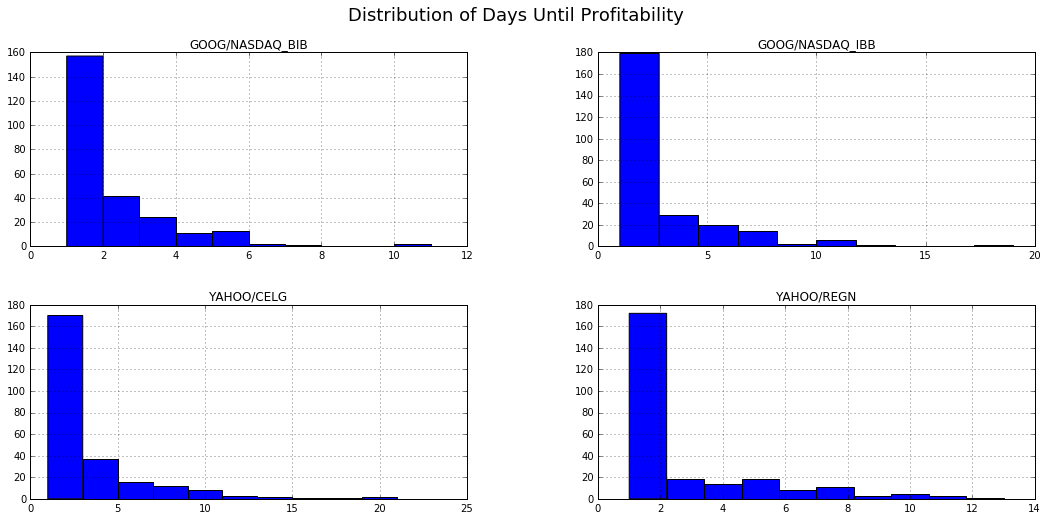

In [22]:
biotech_df.xs('days', axis=1, level=1).hist()
plt.gcf().set_size_inches(18, 8);
plt.gcf().suptitle("Distribution of Days Until Profitability", fontsize=18);

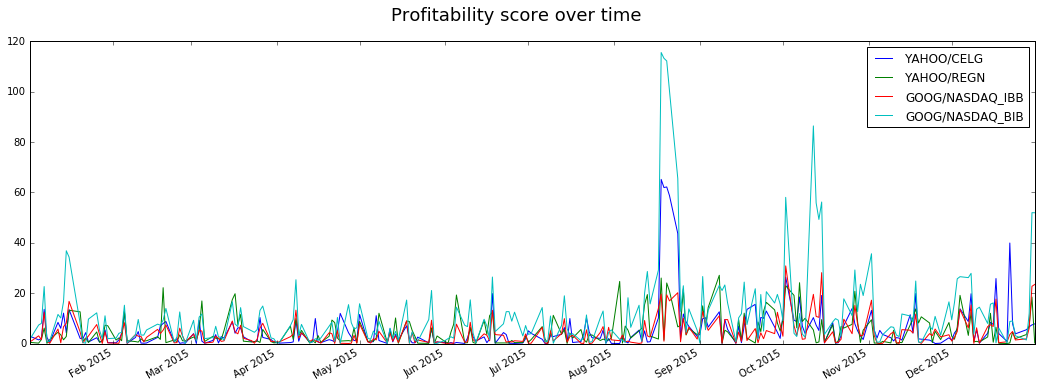

In [23]:
biotech_df.xs('score', axis=1, level=1).plot()
plt.gcf().set_size_inches(18, 6)
plt.gcf().suptitle("Profitability score over time", fontsize=18);

In this example, we don't see a whole lot of interesting things: the scores are all fairly close together with notable exceptions in late August, and mid-October.

What is interesting is that during the volatile period, the ETF's performed significantly better than the stocks did in terms of profitability. The leveraged ETF (BIB) performed far above anyone else, and it appears that indeed, it is most profitable during volatile periods. Even so, it was far more likely to take multiple days to give a return. Its count of 1-day investments trails the other ETF and both stocks by a decent margin.

And consider me an OCD freak, but I just really like Celgene's distribution - it looks nice and smooth.

# Summary and plans for the next post

So far I'm really enjoying playing with this strategy - there's a lot of depth here to understand, though the preliminary results seem to indicate that it profits mostly from taking the other side of a volatile trade. I'd be interested to run results later on data from January - It's been a particularly volatile start to the year so it would be neat to see whether this strategy would work then.

For the next post, I want to start playing with some of the parameters: How do the bias and expected close influence the process? The values have been fairly conservative so far, it will be interesting to see how the simulations respond afterward.